# Gradient-based Markov Chain Monte Carlo

Having introduced first-generation MCMC methods previously, we will now turn our attention to a more sophisticated class of algorithm, which improve upon random-walk jump algorithms by using information about the posterior distribution to inform candidate transitions: namely, gradient information.

While flexible and easy to implement, Metropolis-Hastings sampling is a random walk
sampler that might not be statistically efficient for many models. Specifically, for models of high dimension, random walk jumping algorithms do not perform well. It is not enough to simply guess at the next sample location; we need to make each iteration a useful draw from the posterior whenever we can, in order to have an efficient sampler for bigger models.

![from Hoffman and Gelman 2014](http://d.pr/i/RAA+)

Since Bayesian inference is all about calculating expectations over posteriors, what we seek is an algorithm that explores the area of the parameter space that contains most of the non-zero probability. This region is called the **typical set**.



### What's a Typical Set?

The typical set is where most of the probability density (mass) lies in a particular volume associated with the distribution. As the dimension of a model increases, this set moves progressively further from the mode, and becomes more singular, as the result of concentration of measure.

![mode volume](images/mode_volume.png)

(from *Betancourt 2018*)


The typical set is a product of both the density, which is highest at the mode, and volume (that we integrate over), which increasingly becomes larger away from the mode as dimensionality increases. In fact, at high dimensions, the region around the mode contributes almost nothing to the expectation. We need an algorithm that will find this narrow region and explore it efficiently.

## Hamiltonian Dynamics

In this context, and when sampling from continuous variables, Hamiltonian (or Hybrid) Monte Carlo (HMC) is a powerful tool. It avoids
random walk behavior by simulating a physical system governed by **Hamiltonian dynamics**, potentially avoiding tricky conditional
distributions in the process.

![skate park](images/skate_park.png)

In HMC, model samples are obtained by simulating a physical system, using differential equations, where particles move about a high-dimensional landscape, subject to **potential and kinetic energies**. 

![Hamiltonian dynamics](images/hamiltonian_dynamics.png)

(from *Carroll 2019*)

In the simulations above, momentum is represented by the size and direction of the arrows. Larger (smaller) arrows indicate large kinetic (potential) energy. These trajectories are **energy-conserving**.

Adapting the notation from [Neal (1993)](http://www.cs.toronto.edu/~radford/review.abstract.html), particles are characterized by a position vector or state $s \in \mathcal{R}^D$ and velocity vector $\phi \in \mathcal{R}^D$.

The joint **canonical distribution** of the position and velocity can be expressed as a product of the marginal position (which is of interest) and the conditional distribution of the velocity (a nuisance parameter):

$$\pi(s, \phi) = \pi(\phi | s) \pi(s)$$

This joint probability can also be written in terms of an invariant **Hamiltonian function**:

$$\pi(s, \phi) \propto \exp(-H(s,\phi))$$

The Hamiltonian is then defined as the sum of potential energy $E(s)$ and kinetic energy
$K(\phi)$, as follows:

$$
\mathcal{H}(s,\phi) = E(s) + K(\phi)= E(s) + \frac{1}{2} \sum_i \phi_i^2
$$

Instead of sampling $p(s)$ directly, HMC operates by sampling from the canonical distribution.

$$p(s,\phi) = \frac{1}{Z} \exp(-\mathcal{H}(s,\phi))=p(s)p(\phi)$$.

If we choose a momentum that is independent of position, marginalizing over $\phi$ is trivial and recovers the original distribution of interest.

The Hamiltonian $\mathcal{H}$ is independent of the parameterization of the model, and therefore, captures the geometry of the phase space distribution, including typical set. 

State $s$ and velocity $\phi$ are modified such that
$\mathcal{H}(s,\phi)$ remains constant throughout the simulation. The
differential equations are given by:

$$
\begin{aligned}
\frac{ds_i}{dt} &= \frac{\partial \mathcal{H}}{\partial \phi_i} = \phi_i \\
\frac{d\phi_i}{dt} &= - \frac{\partial \mathcal{H}}{\partial s_i}
= - \frac{\partial E}{\partial s_i}
\end{aligned}
$$

As shown in [Neal (1993)](http://www.cs.toronto.edu/~radford/review.abstract.html), 
the above transformation preserves volume and is
**reversible**. 

> Reversibility is the key property of MCMC algorithms, and is established when the **detailed balance** equation is satisfied:
> $$\pi(x) P(x|y) = \pi(y) P(y|x)$$

The above dynamics can thus be used as transition operators
of a Markov chain and will leave $p(s,\phi)$ invariant. That chain by
itself is not ergodic however, since simulating the dynamics maintains a
fixed Hamiltonian $\mathcal{H}(s,\phi)$. HMC thus alternates Hamiltonian
dynamic steps, with sampling of the velocity. Because $p(s)$ and
$p(\phi)$ are independent, sampling $\phi_{new} \sim p(\phi|s)$ is
trivial since $p(\phi|s)=p(\phi)$, where $p(\phi)$ is often taken to be
the univariate Gaussian.

Other distributions can be chosen for momentum, but a Gaussian allows for the easy calculation of gradients.


### Simulating Hamiltonian Dynamics

In practice, we cannot simulate Hamiltonian dynamics exactly because of the problem of time discretization: its not possible to simulate in continuous time, so we alternate between updating position $s$ and velocity $\phi$. To maintain invariance of the Markov chain however, care must be taken to preserve the properties of *volume conservation* and *time reversibility*. The **leap-frog algorithm** maintains these properties and operates in 3 steps:

$$
\begin{aligned}
\phi_i(t + \epsilon/2) &= \phi_i(t) - \frac{\epsilon}{2} \frac{\partial{}}{\partial s_i} E(s(t)) \\
s_i(t + \epsilon) &= s_i(t) + \epsilon \phi_i(t + \epsilon/2) \\
\phi_i(t + \epsilon) &= \phi_i(t + \epsilon/2) - \frac{\epsilon}{2} \frac{\partial{}}{\partial s_i} E(s(t + \epsilon)) 
\end{aligned}
$$

We thus perform a half-step update of the velocity at time
$t+\epsilon/2$, which is then used to compute $s(t + \epsilon)$ and
$\phi(t + \epsilon)$.

To perform $n$ leapfrog steps, we first need to define a function over
which the algorithm can iterate. Instead of implementing leap frog verbatim, notice that we can obtain
$s(t + n \epsilon)$ and $\phi(t + n \epsilon)$ by performing an initial
half-step update for $\phi$, followed by $n$ full-step updates for
$s,\phi$ and one last half-step update for $\phi$. In loop form, this
gives:

$$
\begin{aligned}\phi_i(t + \epsilon/2) &= \phi_i(t) -
\frac{\epsilon}{2} \frac{\partial{}}{\partial s_i} E(s(t)) \\
s_i(t + \epsilon) &= s_i(t) + \epsilon \phi_i(t + \epsilon/2) \\
\text{For } m \in [2,n]\text{, perform full updates: } \\
\qquad
\phi_i(t + (m - 1/2)\epsilon) &= \phi_i(t + (m-3/2)\epsilon) -
\epsilon \frac{\partial{}}{\partial s_i} E(s(t + (m-1)\epsilon)) \\
\qquad
s_i(t + m\epsilon) &= s_i(t) + \epsilon \phi_i(t + (m-1/2)\epsilon) \\
\phi_i(t + n\epsilon) &= \phi_i(t + (n-1/2)\epsilon) -
\frac{\epsilon}{2} \frac{\partial{}}{\partial s_i} E(s(t + n\epsilon)) 
\end{aligned}
$$

The inner-loop defined above is implemented by the following
`leapfrog` function, with `pos`, `vel` and `step` replacing
$s,\phi$ and $\epsilon$ respectively.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')
import warnings
warnings.simplefilter("ignore")

import theano
from theano import shared, function
import theano.tensor as tt
import pymc3 as pm
import arviz as az

RANDOM_SEED = 20090425

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def simulate_dynamics(initial_pos, initial_vel, stepsize, n_steps, energy_fn):
    

    def leapfrog(pos, vel, step):

        # Gradient calculation
        dE_dpos = tt.grad(energy_fn(pos).sum(), pos)
        
        new_vel = vel - step * dE_dpos
        new_pos = pos + step * new_vel
        return [new_pos, new_vel], {}

    # An initial half-step in velocity
    initial_energy = energy_fn(initial_pos)
    dE_dpos = tt.grad(initial_energy.sum(), initial_pos)
    vel_half_step = initial_vel - 0.5 * stepsize * dE_dpos

    # ... followed by one full position step
    pos_full_step = initial_pos + stepsize * vel_half_step

    # Perform full velocity-step updates afterwards, using scan
    (all_pos, all_vel), scan_updates = theano.scan(leapfrog,
            outputs_info=[
                dict(initial=pos_full_step),
                dict(initial=vel_half_step),
                ],
            non_sequences=[stepsize],
            n_steps=n_steps - 1)
    
    # Our final position after integrating
    final_pos = all_pos[-1]
    final_vel = all_vel[-1]
    
    # One final half-step in velocity to complete the algorithm
    energy = energy_fn(final_pos)
    final_vel = final_vel - 0.5 * stepsize * tt.grad(energy.sum(), final_pos)

    # return new proposal state
    return final_pos, final_vel

Notice that the position update occurs along all dimensions simultaneously, and not just one parameter at a time. This is a noted improvement over the Metropolis-class algorithms.

The arguments of the dynamics function imply a number of decisions that need to be made by the user: How many steps do we want to take? How large should each step be? How much momentum should be provided?

We justified our choice of momentum previously, a random univariate Gaussian. The decisions regarding the number and size of steps has implications for the **path length** used to obtain a sample. Here are three different path lengths and the resulting samples (blue points):

![HMC samples](images/HMC_samples.png)

(from *Carroll 2019*)

As you might expect, different step sizes and numbers are appropriate for different models, depending on the associated geometry, and therefore tuning is usually necessary.

### Accept / Reject

In practice, using finite stepsizes $\epsilon$ will not preserve $\mathcal{H}(s,\phi)$ exactly and will introduce bias in the simulation.
Also, rounding errors due to the use of floating point numbers means that the above transformation will not be perfectly reversible.

HMC cancels these effects **exactly** by adding a Metropolis accept/reject stage, after $n$ leapfrog steps. The new state
$\chi' = (s',\phi')$ is accepted with probability $p_{acc}(\chi,\chi')$, defined as:

$$p_{acc}(\chi,\chi') = min \left( 1, \frac{\exp(-\mathcal{H}(s',\phi')}{\exp(-\mathcal{H}(s,\phi)} \right)$$

### HMC Algorithm

Given all of these components, we can now express the HMC algorithm.

Though there is some complex math involved, the algorithm itself is conceptually simple. It involves three steps:

1.  sample a new velocity from a univariate Gaussian distribution
2.  perform $n$ leapfrog steps to obtain the new state $\chi'$
3.  perform accept/reject move of $\chi'$



The `hmc_move` function below implements a full HMC step. Given a matrix of initial states
$s \in \mathcal{R}^{N \times D}$ (`positions`) and energy function
$E(s)$ (`energy_fn`), it defines the symbolic graph for computing
`n_steps` of HMC, using a given `stepsize`. 

In [3]:
def hmc_move(s_rng, positions, energy_fn, stepsize, n_steps):

    # sample random velocity using independent normals
    initial_vel = s_rng.normal(size=positions.shape)

    # perform simulation of particles subject to Hamiltonian dynamics
    final_pos, final_vel = simulate_dynamics(
            initial_pos=positions,
            initial_vel=initial_vel,
            stepsize=stepsize,
            n_steps=n_steps,
            energy_fn=energy_fn)

    # accept/reject the proposed move based on the joint distribution
    accept = metropolis_hastings_accept(
            energy_prev=hamiltonian(positions, initial_vel, energy_fn),
            energy_next=hamiltonian(final_pos, final_vel, energy_fn),
            s_rng=s_rng)

    return accept, final_pos

where `metropolis_hastings_accept` and `hamiltonian` are helper
functions, defined as follows:

In [4]:
def metropolis_hastings_accept(energy_prev, energy_next, s_rng):
    
    ediff = energy_prev - energy_next
    return (tt.exp(ediff) - s_rng.uniform(size=energy_prev.shape)) >= 0


def kinetic_energy(vel):
    
    return 0.5 * (vel ** 2).sum(axis=1)


def hamiltonian(pos, vel, energy_fn):
    """
    Returns the Hamiltonian (sum of potential and kinetic energy) for the given
    velocity and position. Assumes mass is 1.
    """
    return energy_fn(pos) + kinetic_energy(vel)

What's next? As with Metropolis samplers, we want to be able to **tune** our step size so that it performs integration adequately. The following function implements adaptation by tracking the average acceptance rate of the HMC move proposals across
many simulations, using an exponential moving average with time constant `1 - avg_acceptance_slowness`.

In [5]:
def hmc_updates(positions, stepsize, avg_acceptance_rate, final_pos, accept,
                 target_acceptance_rate, stepsize_inc, stepsize_dec,
                 stepsize_min, stepsize_max, avg_acceptance_slowness):

    """
    POSITION UPDATES
    
    Uses results of the acceptance test to update position
    """

    accept_matrix = accept.dimshuffle(0, *(('x',) * (final_pos.ndim - 1)))
    # if accept is True, update to `final_pos` else stay put
    new_positions = tt.switch(accept_matrix, final_pos, positions)


    """
    STEP SIZE UPDATES
    
    If the acceptance rate is two low, reduce the stepsize; if it is too high, 
    increase the stepsize
    """
    
    _new_stepsize = tt.switch(avg_acceptance_rate > target_acceptance_rate,
                              stepsize * stepsize_inc, stepsize * stepsize_dec)
    # maintain stepsize in [stepsize_min, stepsize_max]
    new_stepsize = tt.clip(_new_stepsize, stepsize_min, stepsize_max)

    # Update acceptance rate with exponential moving average
    mean_dtype = theano.scalar.upcast(accept.dtype, avg_acceptance_rate.dtype)
    new_acceptance_rate = tt.add(
            avg_acceptance_slowness * avg_acceptance_rate,
            (1.0 - avg_acceptance_slowness) * accept.mean(dtype=mean_dtype))

    return [(positions, new_positions),
            (stepsize, new_stepsize),
            (avg_acceptance_rate, new_acceptance_rate)]

Since there are so many interlocking pieces comprising the HMC sampler, its convenient to wrap everything up in a Python class. The constructor creates the symbolic graph for performing an HMC simulation (using `hmc_move` and `hmc_updates`). The graph is then compiled into the `simulate` function, a theano function which runs the simulation and updates the required shared variables. 

The sampler is called via the `draw` method, which calls the Theano function `simulate` and returns a copy of the contents of the shared variable `self.positions`.

In [6]:
def sharedX(X, name):
    return shared(np.asarray(X, dtype=theano.config.floatX), name=name)

class HMC(object):

    def __init__(self, shared_positions, energy_fn,
            initial_stepsize=0.01, target_acceptance_rate=.9, n_steps=20,
            stepsize_dec=0.98,
            stepsize_min=0.001,
            stepsize_max=0.25,
            stepsize_inc=1.02,
            avg_acceptance_slowness=0.9,
            seed=12345):
        
        self.positions = shared_positions
        
        batchsize = shared_positions.shape[0]

        # allocate shared variables
        self.stepsize = stepsize = sharedX(initial_stepsize, 'hmc_stepsize')
        self.avg_acceptance_rate = avg_acceptance_rate = sharedX(target_acceptance_rate,
                                      'avg_acceptance_rate')
        
        s_rng = tt.shared_randomstreams.RandomStreams(seed)

        # define graph for an `n_steps` HMC simulation
        accept, final_pos = hmc_move(
                s_rng,
                shared_positions,
                energy_fn,
                stepsize,
                n_steps)

        # define the dictionary of updates, to apply on every `simulate` call
        simulate_updates = hmc_updates(
                shared_positions,
                stepsize,
                avg_acceptance_rate,
                final_pos=final_pos,
                accept=accept,
                stepsize_min=stepsize_min,
                stepsize_max=stepsize_max,
                stepsize_inc=stepsize_inc,
                stepsize_dec=stepsize_dec,
                target_acceptance_rate=target_acceptance_rate,
                avg_acceptance_slowness=avg_acceptance_slowness)

        # compile theano function
        self.simulate = function([], [], updates=simulate_updates)


    def draw(self, **kwargs):
        """
        Returns a new position obtained after `n_steps` of HMC simulation.
        """
        self.simulate()
        return self.positions.get_value(borrow=False)

### Testing our Sampler

Let's test our implementation of HMC by sampling from a multivariate normal distribution of length 5.

In [7]:
# Simulation hyperparameters
burnin = 2000
n_samples = 1000
dim = 5
batchsize = 3

In [8]:
rng = np.random.RandomState(123)

# Define a covariance and mu for a gaussian
mu  = np.array(rng.rand(dim) * 10, dtype=theano.config.floatX)
cov = np.array(rng.rand(dim, dim), dtype=theano.config.floatX)
cov = (cov + cov.T) / 2.
cov[np.arange(dim), np.arange(dim)] = 1.0
cov_inv = np.linalg.inv(cov)

# Define energy function for a multi-variate Gaussian
def gaussian_energy(x):
    return 0.5 * (tt.dot((x - mu), cov_inv) * (x - mu)).sum(axis=1)

# Declared shared random variable for positions
position = shared(rng.randn(batchsize, dim).astype(theano.config.floatX))

Now, let's initialize our sampler:

In [9]:
sampler = HMC(position, gaussian_energy,
        initial_stepsize=1e-3, stepsize_max=0.5)

Execute some tuning samples, to be discarded.

In [10]:
burn_me = [sampler.draw() for r in range(burnin)]

Now draw `n_samples` for inference. This returns a tensor of dimension `(n_samples, batchsize, dim)`.

In [11]:
samples = np.asarray([sampler.draw() for r in range(n_samples)])
samples = samples.reshape(-1, *samples.shape[-1:])

Estimated values

In [12]:
print('estimated mean: ', samples.mean(axis=0))
print('estimated covariance:\n', np.cov(samples.T))

estimated mean:  [7.01443438 2.8979705  2.33591323 5.57346381 7.25733106]
estimated covariance:
 [[1.04033396 0.6721692  0.7756952  0.60719616 0.39925109]
 [0.6721692  1.03321239 0.34309513 0.48219892 0.42882713]
 [0.7756952  0.34309513 1.10562853 0.69613545 0.44126916]
 [0.60719616 0.48219892 0.69613545 1.07920969 0.55688503]
 [0.39925109 0.42882713 0.44126916 0.55688503 1.06562072]]


For comparison, here are the true parameters.

In [13]:
print('target mean:', mu)
print('target cov:\n', cov)

target mean: [6.96469186 2.86139335 2.26851454 5.51314769 7.1946897 ]
target cov:
 [[1.         0.66197111 0.71141257 0.55766643 0.35753822]
 [0.66197111 1.         0.31053199 0.45455485 0.37991646]
 [0.71141257 0.31053199 1.         0.62800335 0.38004541]
 [0.55766643 0.45455485 0.62800335 1.         0.50807871]
 [0.35753822 0.37991646 0.38004541 0.50807871 1.        ]]


We can also peek at the tuned step size and acceptance rate. Compare this rate to what is targeted in Metropolis sampling.

In [14]:
print('final stepsize', sampler.stepsize.get_value())
print('final acceptance_rate', sampler.avg_acceptance_rate.get_value())

final stepsize 0.5
final acceptance_rate 0.9052926475589113


As can be seen above, the samples generated by our HMC sampler yield an
empirical mean and covariance matrix, which are very close to the true
underlying parameters. The adaptive algorithm also seemed to work well
as the final acceptance rate is close to our target of `0.9`.

## The No U-turn Sampler

Hamiltonian Monte Carlo is a powerful and efficient MCMC sampler when set up appropriately. However, this typically requires careful tuning of the sampler parameters, such as tree depth, leapfrog step size and target acceptance rate. Fortunately, the NUTS algorithm takes care of some of this for us. Nevertheless, tuning must be carefully monitored for failures that frequently arise. This is particularly the case when fitting challenging models, such as those with high curvature or heavy tails.

### Details of NUTS Sampling

NUTS uses a recursive algorithm to build a set of likely candidate points that spans a wide swath of the target distribution. True to its name, it stops automatically when it starts to double back and retrace its steps.

The algorithm employs **binary doubling**, which takes leapfrog steps alternating in direction with respect to the initial gradient. That is, one step is taken in the forward direction, two in the reverse direction, then four, eight, etc. The result is a balanced, binary tree with nodes comprised of Hamiltonian states. 

![](images/binary_doubling.png)

The doubling process builds a balanced binary tree whose leaf nodes correspond to
position-momentum states. The number of doubling events is referred to as the **tree depth** of the simulation.

Doubling is halted when the subtrajectory from the leftmost to the rightmost nodes of any balanced subtree of the overall binary tree starts to double back on itself

![](images/uturn.png)

The important consequence of this approach is that it results in path lengths that are neither too short or too long, but rather, can vary from sample to sample depending on the geometry. 

To ensure detailed balance, a slice variable is sampled from:

$$ u \sim \text{Uniform}(0, \exp[L(\theta) - 0.5 r \cdot r])$$

where $r$ is the initial momentum vector. The next sample is then chosen uniformly from the points in the remaining balanced tree.

## NUTS in PyMC3

Though we have seen how HMC is implemented in Python, we won't concern ourselves with its modified NUTS implementation. Instead, we will use PyMC3 to fit our models from here on out, which has a well-tested and documented version of NUTS that is used as the default sampling method for models consisting of continuous latent variables.

### Example: Estimating IQ impairment from blood phenylalanine for phenylketonuria patients

![pku screening](images/pku_newborn.jpg)

Phenylketonuria (PKU) is a rare genetic disorder that results in a reduced capacity for individuals to metabolize phenylalanine (Phe), resulting in a buildup of the amino acid in the blood stream. The inability to control blood Phe levels is known to lead to severe cognitive impairment in children. The association of blood phenylalanine levels with IQ was meta-analyzed using a hierarchical mixed-effects model ([Fonnesbeck et al., 2012](https://pubmed.ncbi.nlm.nih.gov/23197105/)). The model below is a simplified version of this meta-analysis which we will use to demonstrate the use of NUTS to esitmate models in PyMC3.

In [52]:
pku_data = pd.read_csv('../data/pku_data.csv')
pku_data.head()

,Paper ID,Phe,IQ,Concurrent
0,80,704.0,91.0,1
1,80,1418.0,128.0,1
2,80,1402.0,112.0,1
3,80,1207.0,120.0,1
4,80,2025.0,115.0,1


Extract local variables

In [83]:
unique_papers = set(pku_data['Paper ID'])
paper_map = {p:i for i,p in enumerate(unique_papers)}
paper_id = pku_data['Paper ID'].replace(paper_map)
phe_std = ((pku_data.Phe - pku_data.Phe.mean()) / pku_data.Phe.std()).values
iq = pku_data['IQ'].values
concurrent_measurement = pku_data['Concurrent'].values

In [131]:
def generate_model():

    with pm.Model() as model:

        μ_int = pm.Normal('μ_int', mu=100, sigma=1e3)
        σ_int = pm.HalfCauchy('σ_int', beta=5)
        β_0 = pm.Normal('β_0', μ_int, sigma=σ_int, shape=len(unique_papers))
        β_1 = pm.Normal('β_1', mu=0, sigma=1e3)
        β_2 = pm.Normal('β_2', mu=0, sigma=1e3)

        μ_iq = β_0[paper_id] + β_1*phe_std + β_2*concurrent_measurement

        σ_iq = pm.HalfCauchy('σ_iq', beta=1)
        iq_like = pm.Normal('iq_like', mu=μ_iq, sigma=σ_iq, observed=iq)
        
    return model

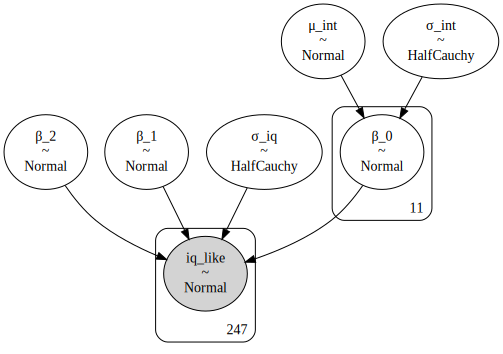

In [132]:
pku_model = generate_model()

pm.model_to_graphviz(pku_model)

### Initialization

A key aspect of using gradient-based MCMC is the initialization of the algorithm. The performance of HMC is generally very sensitive to the **mass matrix** (somethines called the *metric*) that is used to specify the kinetic energy function. Changes in its parameterization will generally affect the efficiency of sampling, as the step size parameter has to be decreased to maintain precision in the simulated trajectories.

Essentially, the optimal mass matrix will be equal to the inverse covariance of the posterior. So, you can use tuning samples to help estimate the sample covariance, and use this estimated matrix as the inverse mass matrix for sampling. The simplest approach is to estimate the diagonal elements of the mass matrix, and use the resulting diagonal matrix for sampling.

PyMC3 comes with a suite of methods for initialization:

* `adapt_diag`: Start with a identity mass matrix and then adapt a diagonal based on the
          variance of the tuning samples. All chains use the test value (usually the prior mean)
          as starting point.
* `jitter+adapt_diag`: Same as `adapt_diag`, but add uniform jitter in \[-1, 1\] to the
          starting point in each chain.
* `advi+adapt_diag`: Run ADVI and then adapt the resulting diagonal mass matrix based on the
          sample variance of the tuning samples.
* `advi+adapt_diag_grad`: Run ADVI and then adapt the resulting diagonal mass matrix based
          on the variance of the gradients during tuning. 
* `map`: Use the MAP as starting point. This is discouraged.
* `advi`: Run ADVI to estimate posterior mean and diagonal mass matrix.
* `advi_map`: Initialize ADVI with MAP and use MAP as starting point.
* `adapt_full`: Adapt a dense mass matrix using the sample covariances

The default method is `jitter+adapt_diag`, as it seems to perform the best across a wide range of problems.

Despite its availability, `map` initialization is not recommended.

In [120]:
pku_model = generate_model()

with pku_model:

    trace = pm.sample(1000, tune=1000, return_inferencedata=True, init='map')

Auto-assigning NUTS sampler...
Initializing NUTS using map...


LinAlgError: 4-th leading minor of the array is not positive definite

In [121]:
pku_model = generate_model()

with pku_model:

    trace = pm.sample(1000, tune=1000, return_inferencedata=True, init='adapt_diag', random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ_iq, β_2, β_1, β_0, σ_int, μ_int]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


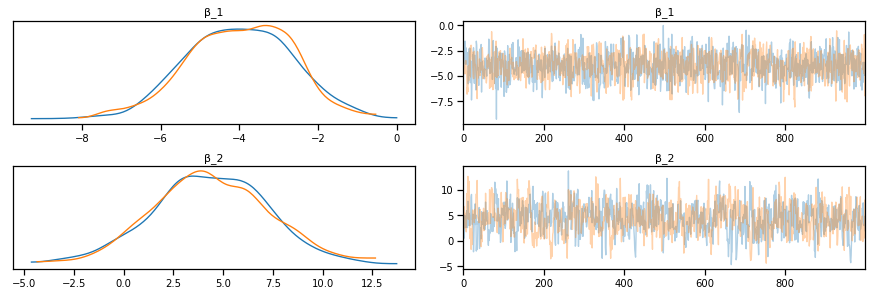

In [122]:
az.plot_trace(trace, var_names=['β_1', 'β_2']);

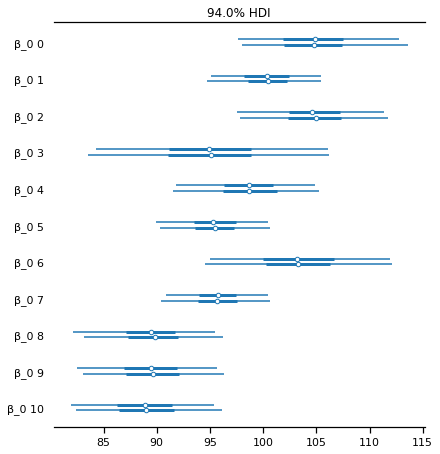

In [123]:
az.plot_forest(trace, var_names=['β_0']);

In [128]:
pku_model = generate_model()

with pku_model:

    trace = pm.sample(1000, tune=1000, return_inferencedata=True, step=pm.HamiltonianMC(), random_seed=RANDOM_SEED)

Multiprocess sampling (2 chains in 2 jobs)
HamiltonianMC: [σ_iq, β_2, β_1, β_0, σ_int, μ_int]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 48 seconds.
The acceptance probability does not match the target. It is 0.7461411907614763, but should be close to 0.65. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


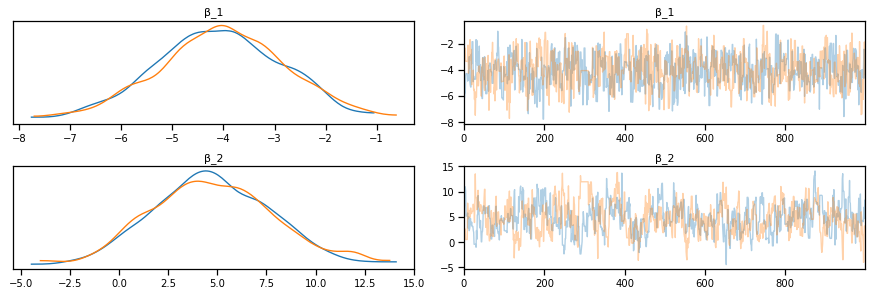

In [129]:
az.plot_trace(trace, var_names=['β_1', 'β_2']);

### Comparison with Metropolis

In [115]:
pku_model = generate_model()

with pku_model:

    trace = pm.sample(1000, tune=1000, return_inferencedata=True, step=pm.Metropolis())

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [σ_iq]
>Metropolis: [β_2]
>Metropolis: [β_1]
>Metropolis: [β_0]
>Metropolis: [σ_int]
>Metropolis: [μ_int]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


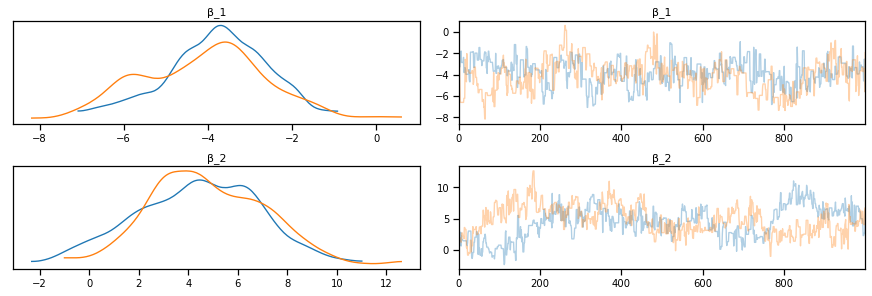

In [116]:
az.plot_trace(trace, var_names=['β_1', 'β_2']);

### NUTS Hyperparameters

In addition to mass matrix adaptation, users can change the default values for the key hyperparameters in NUTS sampling. Specifically, these include:

* `target_accept` : The step size is tuned such that we
  approximate this acceptance rate. Higher values like 0.9 or 0.95 often
  work better for problematic posteriors
* `max_treedepth` : The maximum depth of the trajectory tree, which defaults to 10.
* `step_scale` : The initial guess for the step size scaled down by, according to $(1/n)^{1/4}$

Often, you will receive warning messages that include recommendations for changing the default values of these parameters when there are problems with sampling.

___
## References

1. Team TTD, Al-Rfou R, Alain G, et al. (2016) [Theano: A Python framework for fast computation of mathematical expressions](https://arxiv.org/abs/1605.02688). arXiv.org.
2. Neal, R. M. (2010) [MCMC using Hamiltonian dynamics](http://www.mcmchandbook.net/HandbookChapter5.pdf), in the Handbook of Markov Chain Monte Carlo, S. Brooks, A. Gelman, G. L. Jones, and X.-L. Meng (editors), Chapman & Hall / CRC Press, pp. 113-162.
3. Betancourt, M. (2017). [A Conceptual Introduction to Hamiltonian Monte Carlo](https://arxiv.org/abs/1701.02434). arXiv.org.
4. Carroll, C. (2019) [Hamiltonian Monte Carlo from Scratch](https://colindcarroll.com/2019/04/11/hamiltonian-monte-carlo-from-scratch/)